# Project 1 Notebook

In [41]:
% matplotlib inline

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import numpy as np
import requests
from bs4 import BeautifulSoup 

### Description of the data:
    * State is the most viable Primary Key
    
    * 50 states, Washington DC and the total are included:
        - We need to decide if Washington DC should be included; we will keep it
        - We will remove the 'All' values so it does not corrupt any calculations made
    
    * Understand exactly what 'Rate' we are talking about along with 'Verbal' and 'Math' scores:
        - Rate: State-wide participation in SAT
        - Verbal: mean verbal score per State
        - Math: mean math score per state
        
    * Data types:
        - 'State' is an Object
        - All other columns are Integers

In [43]:
df = pd.read_csv('sat_scores.csv')
df.dtypes

State     object
Rate       int64
Verbal     int64
Math       int64
dtype: object

In [44]:
clean_df = df[df.State != 'All'].copy()
clean_df

,State,Rate,Verbal,Math
0,CT,82,509,510
1,NJ,81,499,513
2,MA,79,511,515
3,NY,77,495,505
4,NH,72,520,516
5,RI,71,501,499
6,PA,71,500,499
7,VT,69,511,506
8,ME,69,506,500
9,VA,68,510,501


In [45]:
list_of_states = list(clean_df.State)
list_participation_rates = list(clean_df.Rate)
list_of_list_example = zip(list_of_states, list_participation_rates)

In [46]:
clean_df.shape

(51, 4)

In [47]:
clean_df.State.nunique()

51

In [48]:
clean_df.mean()

Rate       37.000000
Verbal    532.529412
Math      531.843137
dtype: float64

In [49]:
clean_df.median()

Rate       33.0
Verbal    527.0
Math      525.0
dtype: float64

In [50]:
clean_df.max()

State      WY
Rate       82
Verbal    593
Math      603
dtype: object

In [51]:
clean_df.min()

State      AK
Rate        4
Verbal    482
Math      439
dtype: object

### Exploring the data through visualization 
Below: Initial matplotlib.pyplot visualizations show evidence of a correlation between high mean scores in both verbal and math scores, and low participation rates.

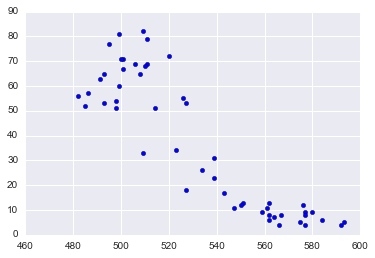

In [52]:
plt.scatter(clean_df.Verbal, clean_df.Rate)
plt.show()

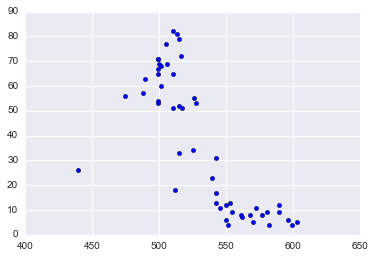

In [53]:
plt.scatter(clean_df.Math, clean_df.Rate)
plt.show()

Below: The distribution of mean verbal scores is significantly tighter than that of math, yet the mean of both sets of mean scores is nearly the same. The set of mean scores for math appears to have a number of low outliers causing greater variance in the data.

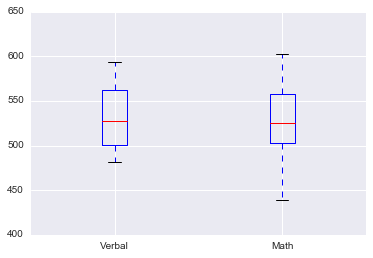

In [54]:
plt.boxplot([clean_df.Verbal, clean_df.Math], labels=['Verbal','Math'])
plt.show()

In [55]:
clean_df.Verbal.var()

1112.934117647059

In [56]:
clean_df.Math.var()

1316.774901960784

Below: There is strong evidence of bimodal distribution within the verbal and math means. What does it 'mean'?

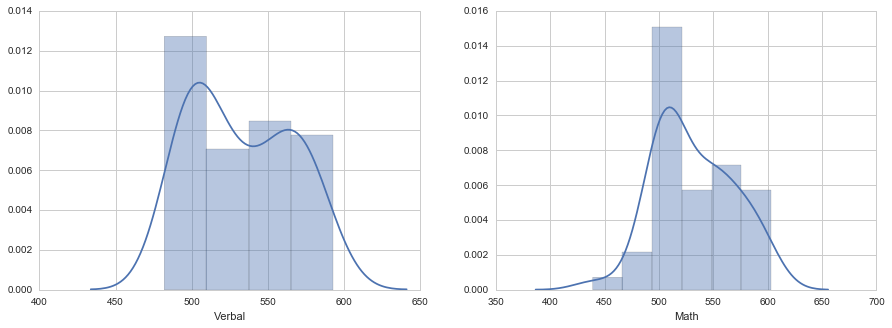

In [57]:
with seaborn.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    seaborn.distplot(clean_df.Verbal, ax=axes[0])
    seaborn.distplot(clean_df.Math, ax=axes[1])
fig, axes

plt.show()

Below: The kernel density graph below confirms that there are two distinct groups.

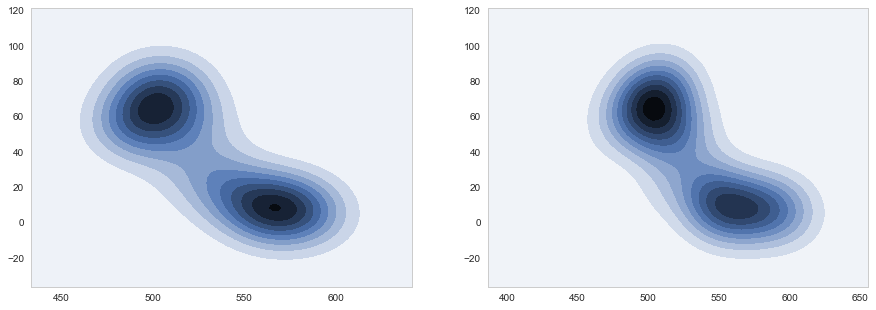

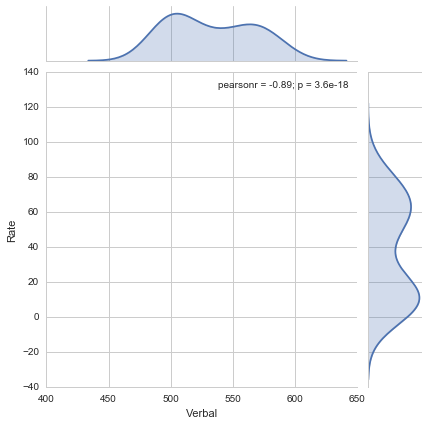

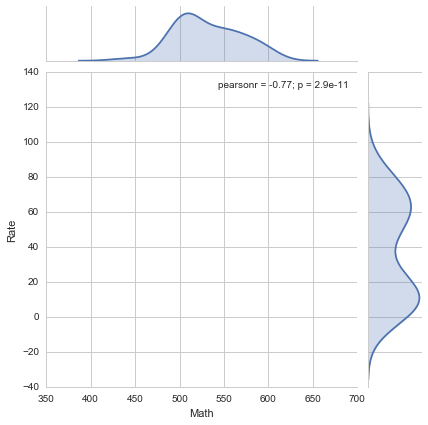

In [77]:
with seaborn.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    seaborn.jointplot(x="Verbal", y="Rate", kind="kde", data=clean_df, ax=axes[0])
    seaborn.jointplot(x="Math", y="Rate", kind="kde", data=clean_df, ax=axes[1])
    
fig, axes

plt.show()

### Define the two distinct groups
    
The groups are defined as having a participationg rate greater than 40 or not.

In [78]:
rate_greater_than_fourty = clean_df.Rate > 40
clean_df['rate_greater_than_40'] = rate_greater_than_fourty

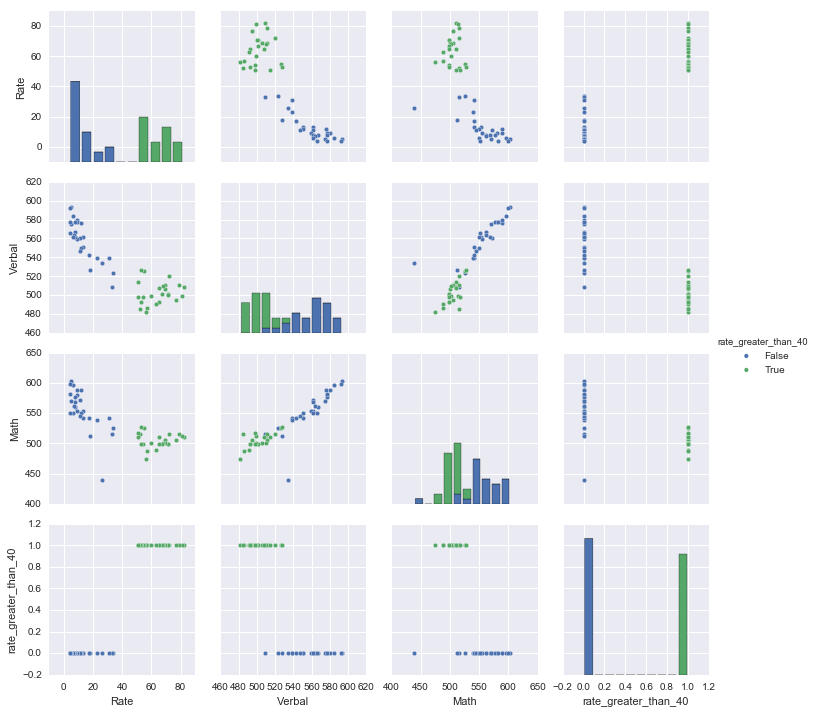

In [79]:
seaborn.pairplot(data=clean_df, hue='rate_greater_than_40')
plt.show() 

Below: States with a participation rate greater than 40 (on the right) tend to have lower mean scores for both verbal and math tests. They also tend to have a tighter distribution of scores. 

Conversely, the distribution of scores of States under 40 is much greater. This may suggest greater homogeneity amongst States with greater participation rates. 

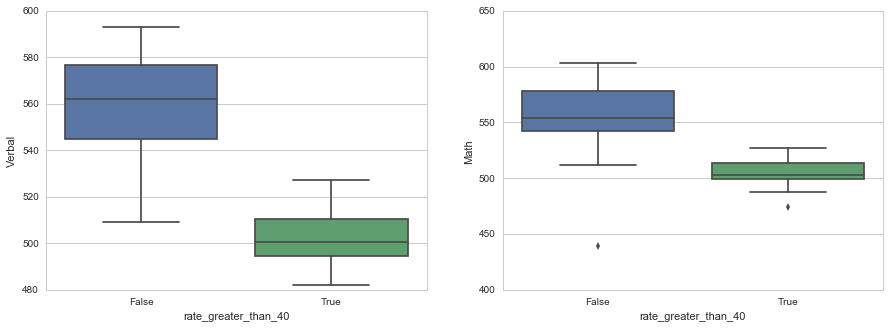

In [80]:
with seaborn.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    seaborn.boxplot(x='rate_greater_than_40', y='Verbal', data=clean_df, ax=axes[0])
    seaborn.boxplot(x='rate_greater_than_40', y='Math', data=clean_df, ax=axes[1])
    
fig, axes

plt.show()

### Pull external information into the dataset
This will help create a robust analyse of the SAT scores and participation rate, and hopefully bring some understanding to the bimodal distribution seen above.
    
    Investigate the impact of the following on SAT scores and participation rate: 

    * State population
    * Agriculture

##### Impact of State population

In [81]:
url = 'https://people.sc.fsu.edu/~jburkardt/datasets/census/census_2010.txt'
req = requests.get(url)

In [82]:
US_States = []
State_Pop = [] 

for line in req.text.split('\n'):
    if line != '':
        US_States.append((line[0:2]))
        pop = int(line[4:].replace(',','').replace(' ', '').replace('\t', '').encode('utf-8'))
        State_Pop.append(pop)
    
State_Pop_Table = zip(US_States, State_Pop)

State_Pop_DF = pd.DataFrame(data=State_Pop_Table, columns=('US_States','State_Pop'))

In [83]:
df_w_pop = clean_df.merge(State_Pop_DF, how='left', left_on=clean_df.State, right_on=State_Pop_DF.US_States).copy()

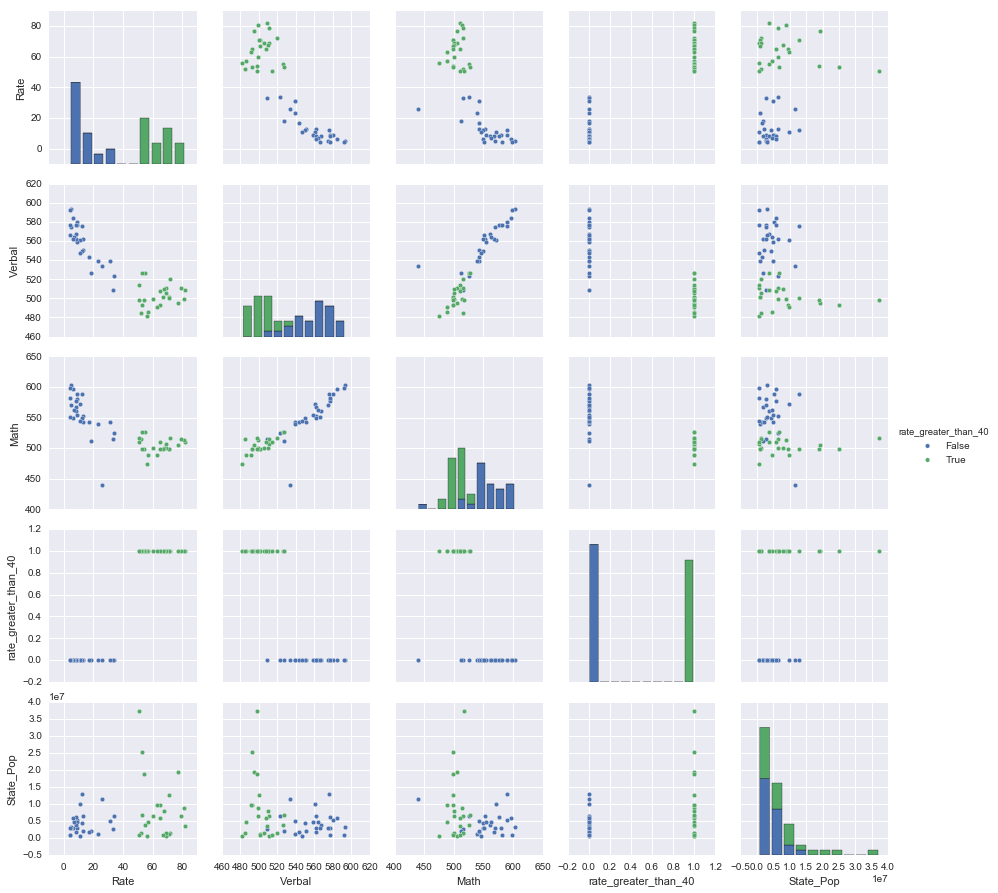

In [84]:
seaborn.pairplot(data=df_w_pop, hue='rate_greater_than_40')
plt.show()

Below: Population does not correlate to participation rate.

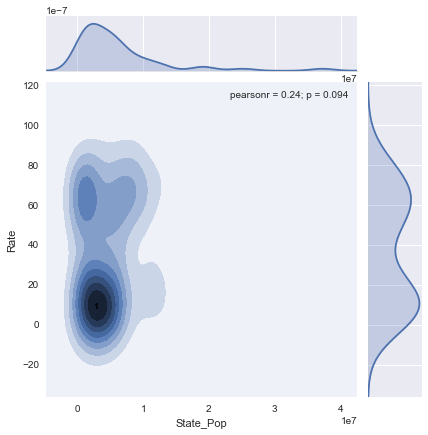

In [85]:
seaborn.jointplot(x='State_Pop', y='Rate', kind="kde", data=df_w_pop)
plt.show()

Below: This lack of correlation to population holds true even when the data is subset into groups greater and less than 40% participation.

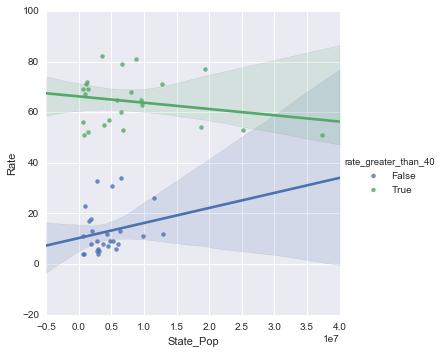

In [86]:
seaborn.lmplot(x='State_Pop', y='Rate', data=df_w_pop, hue='rate_greater_than_40')
plt.show()

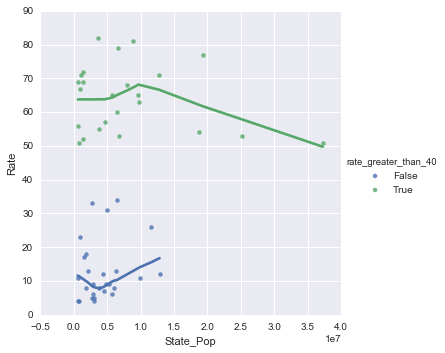

In [87]:
seaborn.lmplot(x="State_Pop", y="Rate", data=df_w_pop, lowess=True, hue="rate_greater_than_40")
plt.show()

Below: There is, however, less variation of population size amongs state with a participation rate below 40.

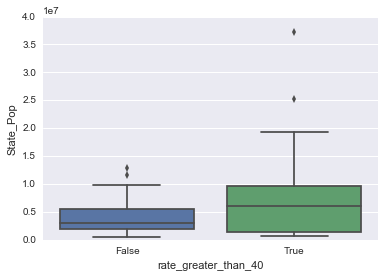

In [88]:
seaborn.boxplot(x='rate_greater_than_40', y='State_Pop', data=df_w_pop)
plt.show()

Below: Correlation between between population and math and/or verbal scores is also not significant. 

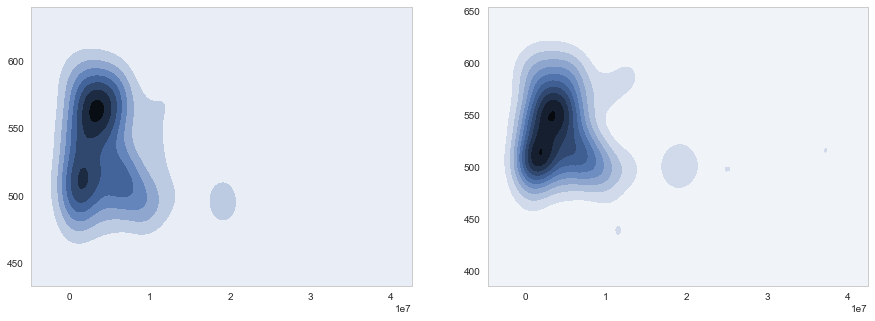

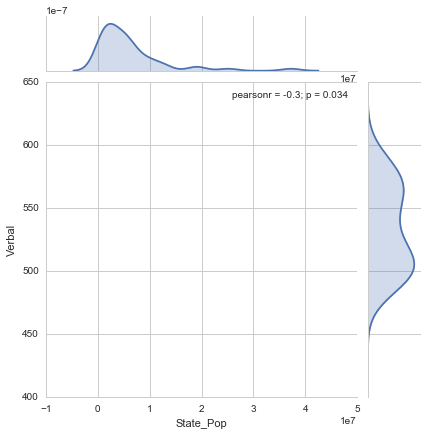

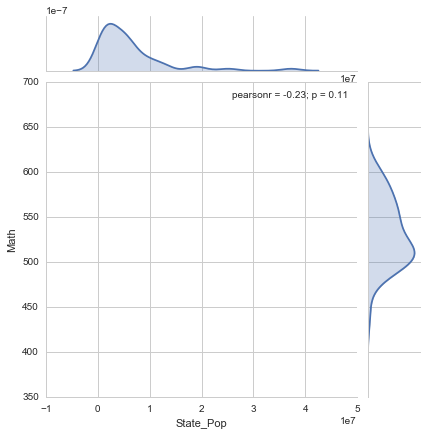

In [89]:
with seaborn.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    seaborn.jointplot(x="State_Pop", y="Verbal", kind="kde", data=df_w_pop, ax=axes[0])
    seaborn.jointplot(x="State_Pop", y="Math", kind="kde", data=df_w_pop, ax=axes[1])
    
fig, axes

plt.show()

##### Impact of agriculture

In [90]:
ag_data = pd.read_excel('FSA_Crop_National_Data_2011-15.xlsx')

In [91]:
df_w_ag = df_w_pop.merge(ag_data, how='left', on='State')

In [94]:
df_w_ag

,State,Rate,Verbal,Math,rate_greater_than_40,US_States,State_Pop,Planted_Acres
0,CT,82,509,510,True,CT,3574097,4.358388e+06
1,NJ,81,499,513,True,NJ,8791894,7.227234e+06
2,MA,79,511,515,True,MA,6547629,1.354221e+06
3,NY,77,495,505,True,NY,19378102,7.517629e+07
4,NH,72,520,516,True,NH,1316470,1.846348e+06
5,RI,71,501,499,True,RI,1052567,2.375515e+05
6,PA,71,500,499,True,PA,12702379,3.709844e+07
7,VT,69,511,506,True,VT,625741,5.147201e+06
8,ME,69,506,500,True,ME,1328361,3.027834e+06
9,VA,68,510,501,True,VA,8001024,3.346209e+07


In [95]:
df_w_ag['Planted_Acres_per_Capita'] = df_w_ag.Planted_Acres / df_w_ag.State_Pop

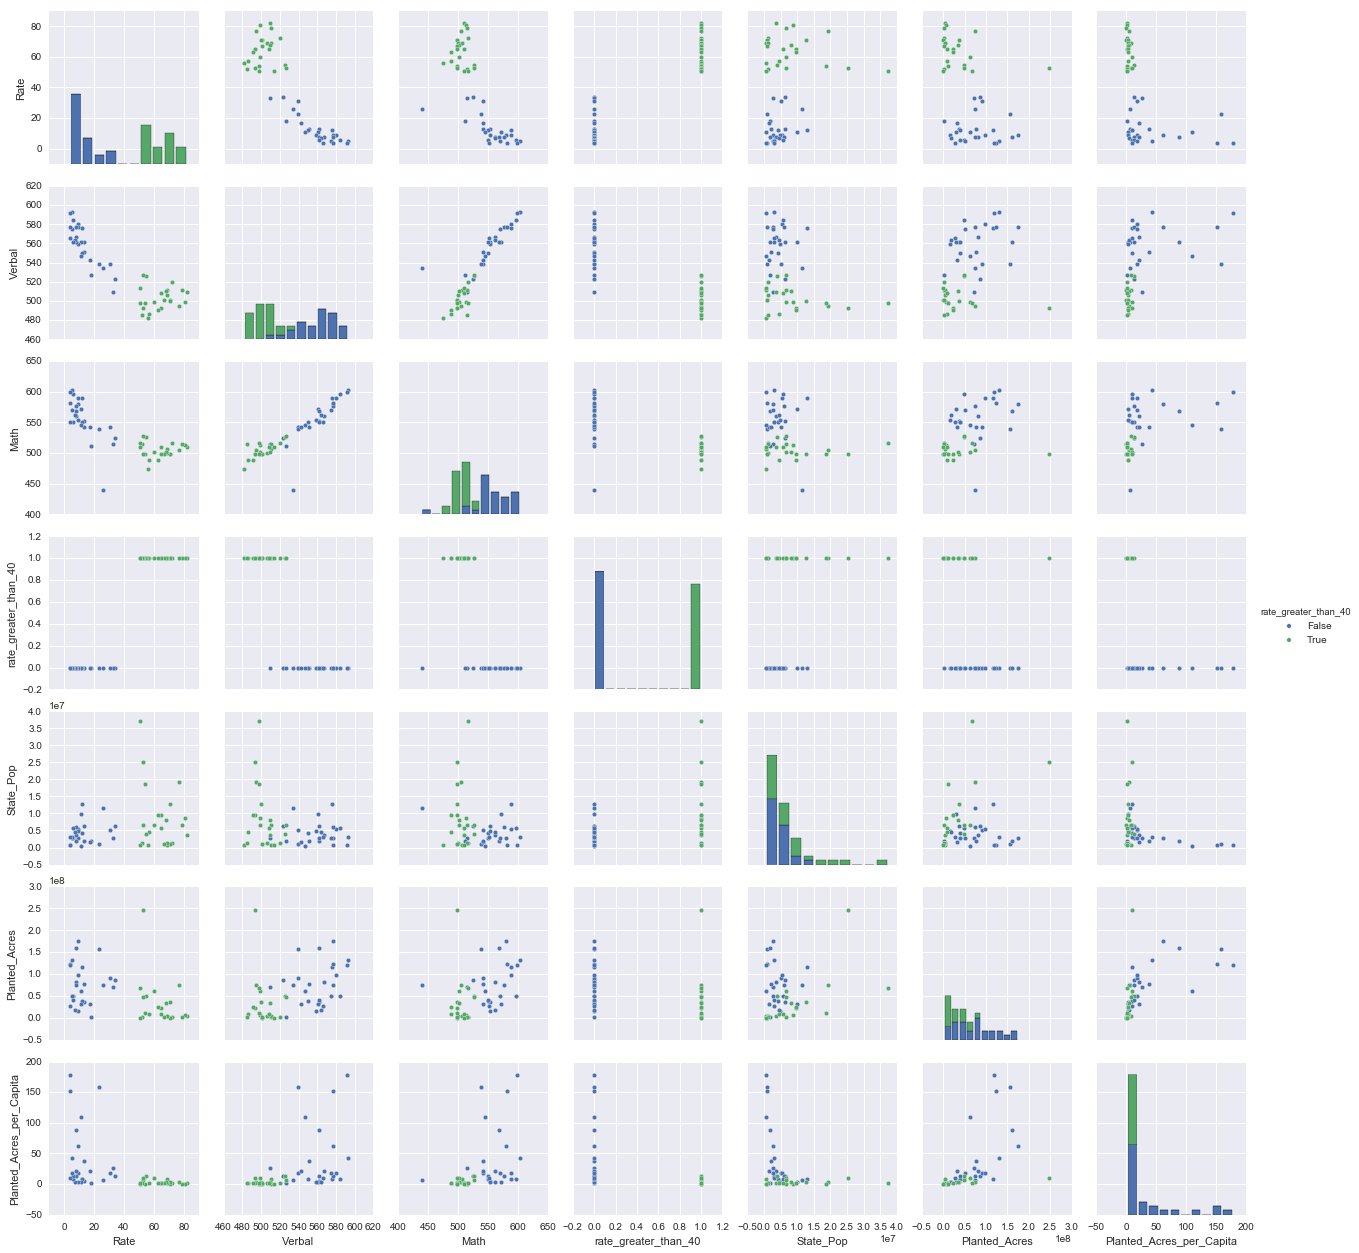

In [96]:
seaborn.pairplot(data=df_w_ag, hue='rate_greater_than_40')
plt.show()

Below: The figure below clearly illustrates that States with high participation rates do not have high amounts of agriculture per capita (i.e. agriculture probably does not play a huge role in the economy). 

Conversely, many States with low participation rates appear to have high amounts of agriculture per capita; this should be tempered by the fact that the distribution of agriculture per capita amongs low-participation states may mean agriculture does not always effect participation rate.

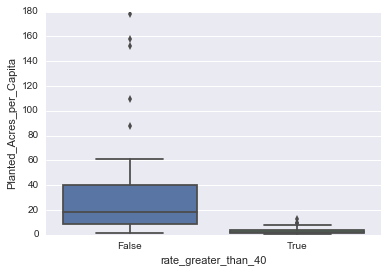

In [97]:
seaborn.boxplot(y='Planted_Acres_per_Capita', x='rate_greater_than_40', data=df_w_ag)
plt.show()

##### Deeper analysis of low participation rate States.

In [98]:
low_rate_states = pd.DataFrame(df_w_ag[df_w_ag.rate_greater_than_40 == False])

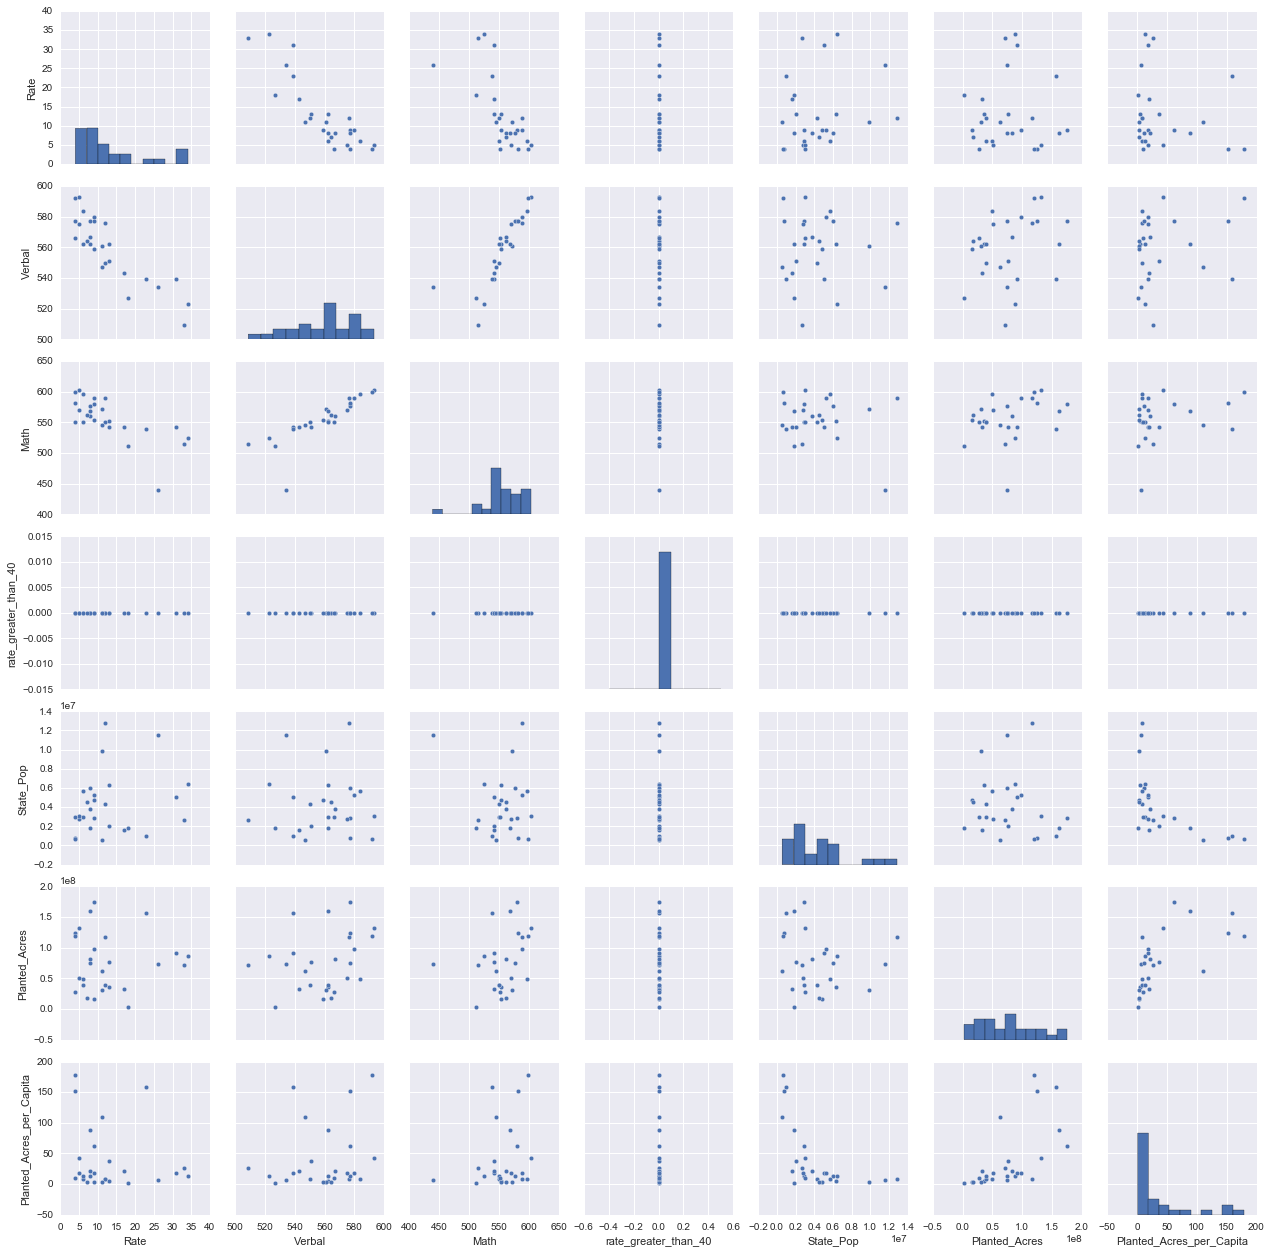

In [99]:
seaborn.pairplot(data=low_rate_states)
plt.show()

Below: Note the cluster of states with low participation rate and low levels of agriculture. This does not support the idea that agriculture plays a significant role in high or low participation rates. 

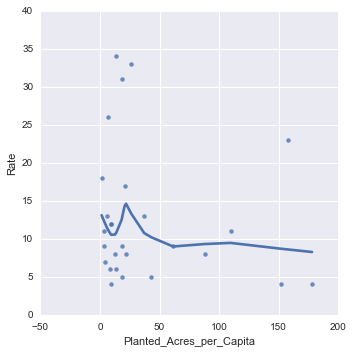

In [100]:
seaborn.lmplot(x="Planted_Acres_per_Capita", y="Rate", data=low_rate_states, lowess=True)
plt.show()

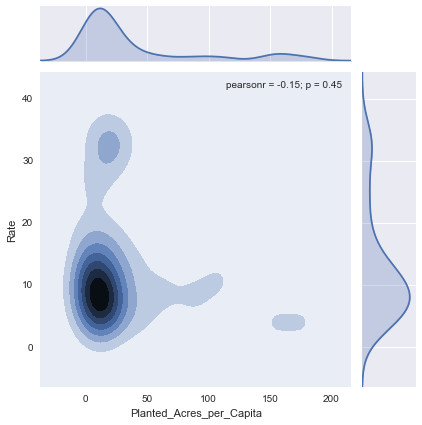

In [101]:
seaborn.jointplot(x="Planted_Acres_per_Capita", y="Rate", data=low_rate_states, kind='kde')
plt.show()

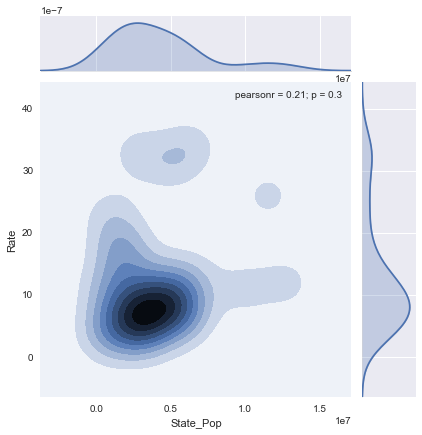

In [102]:
seaborn.jointplot(x="State_Pop", y="Rate", data=low_rate_states, kind='kde')
plt.show()

### Map visualisations

It is clear that agriculture may play a role in participation rates. It is also clear that it does not play a role in higher participation rates, but the shape of agriculture's role in States with lower rates is unclear. 

At this point I feel it would be appropriate to visualise this dataset on a map of the United Sates. We will does this using Tableau. This may help catalyse ideas for what drives participation rates in high-rate States, and what role agriculture and other factors may play in low-rate States.

See the Tableau dashboard visualisation here:
https://public.tableau.com/profile/publish/DSI1_Project1_Byron_Allen/DSI1_Project1#!/publish-confirm

In [103]:
df_w_ag.to_csv(path_or_buf='df_w_ag.csv')

In [104]:
df_w_ag

,State,Rate,Verbal,Math,rate_greater_than_40,US_States,State_Pop,Planted_Acres,Planted_Acres_per_Capita
0,CT,82,509,510,True,CT,3574097,4.358388e+06,1.219438
1,NJ,81,499,513,True,NJ,8791894,7.227234e+06,0.822034
2,MA,79,511,515,True,MA,6547629,1.354221e+06,0.206826
3,NY,77,495,505,True,NY,19378102,7.517629e+07,3.879446
4,NH,72,520,516,True,NH,1316470,1.846348e+06,1.402499
5,RI,71,501,499,True,RI,1052567,2.375515e+05,0.225688
6,PA,71,500,499,True,PA,12702379,3.709844e+07,2.920590
7,VT,69,511,506,True,VT,625741,5.147201e+06,8.225769
8,ME,69,506,500,True,ME,1328361,3.027834e+06,2.279376
9,VA,68,510,501,True,VA,8001024,3.346209e+07,4.182225


# Excercise for Class 6

In [105]:
import statsmodels
import statsmodels.stats.weightstats as ssw
import statsmodels.stats.proportion as ssp
import scipy
import scipy.stats as ss
import random

Compare the probability that low-rate states were the same scores as high rate states.

In [113]:
high_rates_math = df_w_ag[df_w_ag.rate_greater_than_40 == True].Math
low_rates_math = df_w_ag[df_w_ag.rate_greater_than_40 == False].Math

In [141]:
ssw.ttest_ind(low_rates_math, high_rates_math, value=df_w_ag.Math.mean())

(-66.186127985830424, 1.351486132157647e-49, 49.0)

In [112]:
ss.mannwhitneyu(low_rates_math, high_rates_math)

MannwhitneyuResult(statistic=610.0, pvalue=6.8961239458609033e-08)

In [118]:
all_math_scores = df_w_ag.Math
ohio_math_scores = df_w_ag[df_w_ag.State == 'OH'].Math

In [123]:
ssw.ttest_ind(ohio_math_scores, all_math_scores)

(-2.5338298808914526, 0.014462397243676102, 50.0)

In [124]:
ss.mannwhitneyu(ohio_math_scores, all_math_scores)

MannwhitneyuResult(statistic=0.5, pvalue=0.10221548974540895)

Below: Teacher's example

In [135]:
highest_bad_rate = df_w_ag.Rate.nsmallest(10).max()
lowest_good_rate = df_w_ag.Rate.nlargest(10).min()

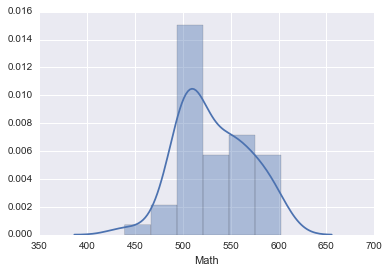

In [133]:
seaborn.distplot(df_w_ag.Math)

In [132]:
lowest_good_rate

68

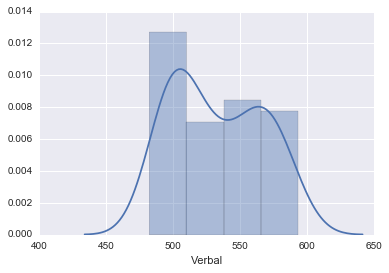

In [134]:
seaborn.distplot(df_w_ag.Verbal)

In [137]:
ztest = ssw.ztest

ztest(low_rate_states.Math, value=df_w_ag.Math.mean())

(3.6941474362865834, 0.00022062577020962927)